# Patient Selection for Diabetes Drug Testing - AI techniques

**Part**
1. Background & EHR Data Source
2. Data Preparation & Engineering using Tensorflow Dataset API
3. Create Categorical/Continuous/Numerical Features with [Tensorflow Feature Columns](https://www.tensorflow.org/tutorials/structured_data/feature_columns)
4. Build Deep Learning Regression Model with [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) and [TF Probability Layers](https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression)
5. Evaluating Potential Model Biases with [Aequitas Bias & Fairness Audit Toolkit](https://dssg.github.io/aequitas/)

**Key Points**
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 

#  1. Background & EHR Data Source

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). I'm playing a role as a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. I have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring. I would build a regression model that can predict the estimated hospitalization time for a patient and use this to select patients for clinical trial research.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, I would build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

**Data Source** Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. We are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified, which represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2. Data Preparation & Engineering

In [1]:
# Import Package

import os
#OPEN ISSUE ON MAC OSX for TF model training
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp

import aequitas as ae

# Customized Function
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
from sklearn.metrics import f1_score, classification_report, roc_auc_score

pd.set_option('display.max_columns', 500)

# make changes and save in utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload
%reload_ext autoreload

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [2]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)
df.shape

(143424, 26)

In [3]:
print('Total rows of dataset: {}'.format(len(df)))
print('Total unique encounters of dataset: {}'.format(df['encounter_id'].nunique()))

Total rows of dataset: 143424
Total unique encounters of dataset: 101766


Total rows > number of unique encounters, so the dataset is the line level. Key fields to aggregate on: encounter_id, patient_nbr, and primary_diagnosis_code.

In [4]:
df.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [5]:
# Data Schema Reference files
def load_schema_ref_df(fileName):
    new_df = pd.read_csv(os.path.join('..','data_schema_references', fileName))
    return new_df

IDs_mapping = load_schema_ref_df('IDs_mapping.csv')
ndc_lookup_table = load_schema_ref_df('ndc_lookup_table.csv')
project_data_schema = load_schema_ref_df('project_data_schema.csv')

In [6]:
# Data Schema
project_data_schema

,Feature Name\n,Type,Description
0,encounter_id,numeric ID\n,Unique identifier of an encounter
1,patient_nbr,numeric ID\n,Unique identifier of a patient
2,race,categorical,"Values: Caucasian, Asian, African American, Hi..."
3,gender,categorical,"Values: male, female, and unknown/invalid"
4,age,bucketed numerical feature (converted to categ...,"Grouped in 10-year intervals: [0, 10), [10, 20..."
5,weight,numerical,Weight in pounds.
6,admission_type_id,categorical,Integer identifier corresponding to 9 distinct...
7,discharge_disposition_id,categorical,Integer identifier corresponding to 29 distinc...
8,admission_source_id,categorical,nteger identifier corresponding to 21 distinct...
9,time_in_hospital,numerical,Integer number of days between admission and d...


In [7]:
# admission_type_id, discharge_disposition_id, admission_source_id
IDs_mapping.head(5)

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [8]:
# NDC code
ndc_lookup_table.T.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268
NDC_Code,0087-6060,0087-6063,0087-6064,0087-6070,0087-6071,0093-7212,0093-7267,0093-7455,0093-7456,0093-7457,0179-0205,0185-4416,0228-2751,0228-2752,0228-2753,0378-7185,0378-7186,0378-7187,0591-2411,0591-2412,0591-2719,0591-2720,0615-7982,0615-8015,0615-8289,0781-5503,0781-5626,0781-5627,0904-6326,0904-6328,0904-6689,0904-6690,0904-6691,10631-019,10631-206,10631-238,12634-756,12634-757,12634-789,13668-280,13668-281,16714-938,16714-939,23155-102,23155-103,23155-104,23155-115,23155-116,23155-117,23155-233,23155-234,23155-235,24658-790,24658-791,24658-792,24724-014,24724-015,24724-016,25000-101,25000-102,25000-131,25000-132,25000-134,29033-031,29033-032,33261-145,33261-157,33261-372,33342-141,33342-142,33342-143,33342-176,33342-177,33342-239,33342-240,35208-001,35208-002,35356-886,42291-305,42291-306,42291-558,42291-559,42291-582,42291-583,42291-605,42291-606,42291-607,42291-610,42291-611,42385-902,42385-903,42385-904,42708-009,0169-0081,0169-0082,0169-0084,0574-0240,0574-0241,0574-0242,51991-853,51991-854,51991-855,57237-157,57237-158,57237-159,57664-745,57664-747,60429-484,60429-485,60429-486,60846-882,60846-884,65862-670,65862-671,65862-672,68084-954,68084-967,0078-0351,0078-0352,0591-3354,0591-3355,42291-636,42291-637,49884-984,49884-985,52536-063,52536-067,55111-328,55111-329,60429-434,60429-435,68084-458,68084-459,68382-721,68382-722,70771-1015,70771-1016,71209-030,71209-031,75834-205,75834-206,0039-0221,0039-0222,0039-0223,0093-7254,0093-7255,0093-7256,0378-4011,0378-4012,0378-4013,0781-5634,0781-5635,16729-001,16729-002,16729-003,33261-831,33261-892,33261-961,42571-100,42571-101,42571-102,42571-103,42571-104,42571-105,42708-083,43063-121,43063-587,43063-630,43063-697,43063-698,43063-699,43063-946,43547-394,43547-395,43547-396,50090-1526,50090-1987,50090-2485,50090-2486,50090-3172,50090-3547,50268-358,50268-359,50268-360,50436-7073,51079-425,51079-426,51655-103,51655-120,51655-381,53217-250,53217-285,53217-320,53217-323,54458-966,54458-967,55111-320,55111-321,0049-0170,0049-0174,0049-0178,0049-4110,0049-4120,0378-1105,0378-1110,0591-0460,0591-0461,0009-0341,0009-0352,0009-3449,0093-8034,0093-8035,0093-8036,0093-8342,0093-8343,0093-8344,0093-9364,0093-9433,0093-9477,0115-1742,0115-1743,0115-1744,0143-9918,0143-9919,0143-9920,0378-0215,0093-7271,0093-7272,0093-7273,0378-0048,0378-0228,0378-0318,0781-5420,0781-5421,0781-5422,0173-0861,0173-0863,0054-0140,0054-0141,0054-0142,23155-147,23155-148,23155-149,42291-130,42291-131,42291-132,0009-5012,0009-5013,0009-5014,57664-684,57664-685,57664-686,76333-125,76333-126,76333-127,0378-0217,0378-0551,68071-1701,47918-880,47918-891,47918-898,47918-902,50090-0353,0781-5634,0781-5635,64764-302,64764-304,66993-821,66993-822
Proprietary Name,Glucophage,Glucophage XR,Glucophage XR,Glucophage,Glucophage,Metformin Hydrochloride,Metformin Hydrochloride,Glipizide And Metformin Hydrochloride,Glipizide And Metformin Hydrochloride,Glipizide And Metformin Hydrochloride,Glipizide And Metformin Hydrochloride,Metformin Hydrochloride,Glyburide And Metform

## EDA

### Check null/missing value

In [9]:
df_copy = df.replace({'?':np.nan})

In [10]:
def check_null_values(df):
    null_df = pd.DataFrame({'columns': df.columns, 
                            'percent_null': df.isnull().sum() * 100 / len(df), 
                            'percent_zero': df.isin([0]).sum() * 100 / len(df)
                           } )
    return null_df

check_null_values(df_copy)

,columns,percent_null,percent_zero
encounter_id,encounter_id,0.000000,0.000000
patient_nbr,patient_nbr,0.000000,0.000000
race,race,2.307145,0.000000
gender,gender,0.000000,0.000000
age,age,0.000000,0.000000
weight,weight,97.000502,0.000000
admission_type_id,admission_type_id,0.000000,0.000000
discharge_disposition_id,discharge_disposition_id,0.000000,0.000000
admission_source_id,admission_source_id,0.000000,0.000000
time_in_hospital,time_in_hospital,0.000000,0.000000


### Continuous variable  distribution

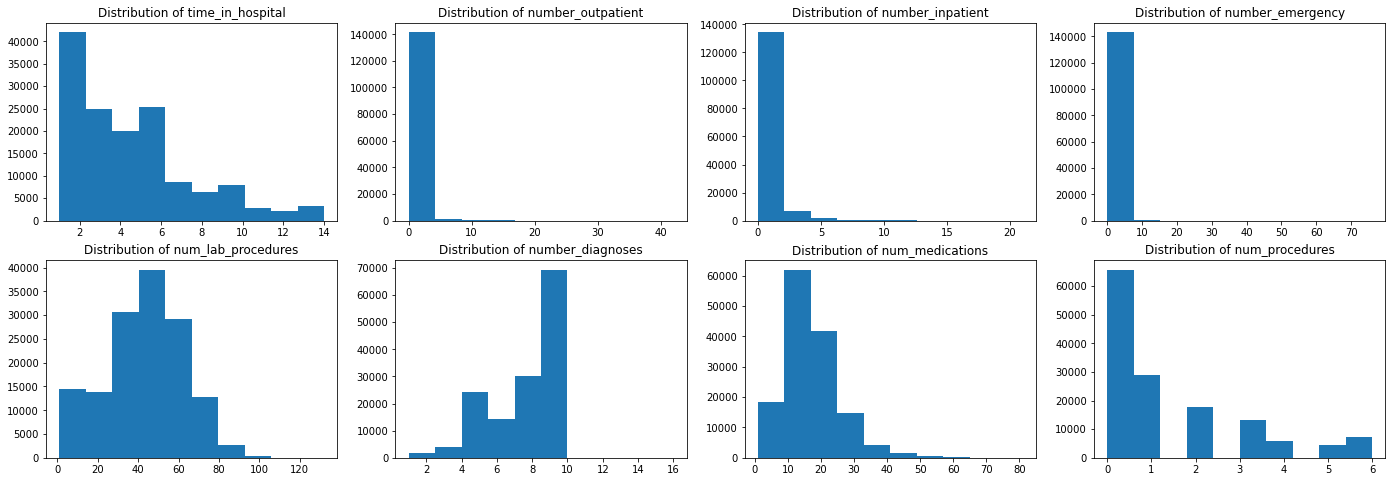

In [11]:
# Distribution for the numerical features
numerical_feature_list = ['time_in_hospital', 'number_outpatient', 'number_inpatient', 'number_emergency',
                          'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']
nb_of_lines = 2
nb_of_clmns = 4
fig, m_axs = plt.subplots(nb_of_lines, nb_of_clmns, figsize = (nb_of_clmns*6, nb_of_lines*4))
for (index, c_ax) in zip([i for i in range(nb_of_lines*nb_of_clmns)], m_axs.flatten()):
    c_ax.hist(df_copy[numerical_feature_list[index]].astype('float'))
    c_ax.set_title(f"Distribution of {numerical_feature_list[index]}")

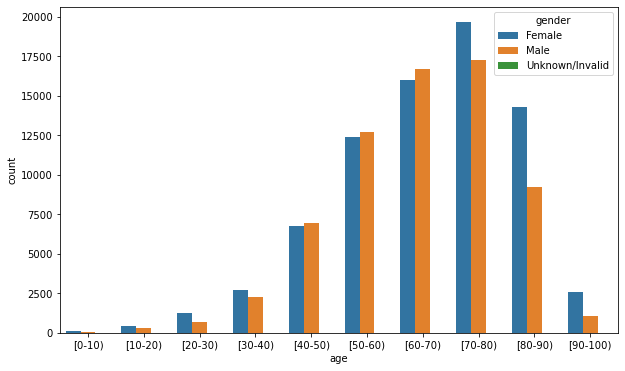

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(x="age", hue="gender", data=df_copy)

### Categorical variables cardinality (unique labels)

In [13]:
def create_cardinality_feature(df):
    num_rows = len(df)
    random_code_list = np.arange(100, 1000, 1)
    return np.random.choice(random_code_list, num_rows)
    
def count_unique_values(df, cat_col_list):
    cat_df = df[cat_col_list].copy()
    cat_df['principal_diagnosis_code'] = create_cardinality_feature(cat_df)
    #add feature with high cardinality
    val_df = pd.DataFrame({'columns': cat_df.columns, 
                       'cardinality': cat_df.nunique() } )
    return val_df

categorical_feature_list = ["race", "gender", "admission_type_id", "discharge_disposition_id",
                            "admission_source_id", "payer_code", "medical_specialty", "primary_diagnosis_code",
                            "ndc_code", "max_glu_serum", "A1Cresult", "change"]

count_unique_values(df_copy, categorical_feature_list)

,columns,cardinality
race,race,5
gender,gender,3
admission_type_id,admission_type_id,8
discharge_disposition_id,discharge_disposition_id,26
admission_source_id,admission_source_id,17
payer_code,payer_code,17
medical_specialty,medical_specialty,72
primary_diagnosis_code,primary_diagnosis_code,716
ndc_code,ndc_code,251
max_glu_serum,max_glu_serum,4


In [14]:
# delete df_copy when the EDA is over
del(df_copy)

**EDA insights** 
  - With a high amount of null/missing values: "weight", "payer_code", "medical_specialty" fields with a high amount of zero values: "number_inpatient", "number_outpatient", "num_procedures", "number_ermergency"
  - Most ditributions are skewed but the following are Gaussian: age, weight, num_lab_procedures and num_medications.

  - High cardinality categorical variables:
     - Primary diagnosis codes and Principle diagnosis codes: there are 14025 Dx codes in the ICD9-CM code set
     - NDC codes: each NDC code represent product, labeler, package and company information of one type of drug
     - Medical specialty: the specialty of the admitting physician
 
  - Demographic distributions for the age and gender fields. 
     - Distributions of age is Gaussian and similar for both male and female and the gender distribution is relatively uniform for male and female.

## Reduce Dimensionality of the NDC Code Feature

NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/).

In [15]:
# NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [16]:
%run utils.py

In [17]:
from utils import reduce_dimension_ndc

In [18]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [19]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()
print(f"Number of unique drug values has been reduced from {df['ndc_code'].nunique()} (NDC codes) to {reduce_dim_df['generic_drug_name'].nunique()} (GNN-Generic Drug Name)")

Number of unique drug values has been reduced from 251 (NDC codes) to 22 (GNN-Generic Drug Name)


In [20]:
# reduce_dim_df = reduce_dim_df.drop(['ndc_code'], axis=1)

In [21]:
reduce_dim_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted',
       'generic_drug_name'],
      dtype='object')

## Select First Encounter for each Patient

In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps.

In [22]:
from utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [23]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

Creating dummy columns for each unique generic drug name (GNN) and adding those are input features to the model.

In [24]:
def aggregate_dataset(df, grouping_field_list,  array_field):
    df = df.groupby(grouping_field_list)[['encounter_id', array_field]].apply(
                lambda x: x[array_field].values.tolist()).reset_index().rename(columns={0: array_field + "_array"}) 
    
    dummy_df = pd.get_dummies(df[array_field + '_array'].apply(pd.Series).stack()).sum(level=0)
    dummy_col_list = [x.replace(" ", "_") for x in list(dummy_df.columns)] 
    mapping_name_dict = dict(zip([x for x in list(dummy_df.columns)], dummy_col_list ) ) 
    concat_df = pd.concat([df, dummy_df], axis=1)
    new_col_list = [x.replace(" ", "_") for x in list(concat_df.columns)] 
    concat_df.columns = new_col_list

    return concat_df, dummy_col_list

In [25]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

In [26]:
agg_drug_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,None,None,Ch,NO,"[Glipizide, Insulin Human]",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,None,None,Ch,NO,"[Rosiglitazone Maleate, Human Insulin]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,None,None,Ch,NO,"[Glipizide, Human Insulin]",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,None,None,No,>30,[Human Insulin],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,None,None,No,>30,[Insulin Human],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71513,443842016,183087545,Caucasian,Female,[70-80),?,1,1,7,9,?,?,574,574|250.02,0,0,0,50,9,33,2,None,>7,Ch,>30,"[Glyburide, Insulin Human]",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71514,443842022,188574944,Other,Female,[40-50),?,1,1,7,14,MD,?,592,599|518,0,0,1,73,9,26,6,None,>8,Ch,>30,"[Glipizide, Human Insulin]",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71515,443842070,140199494,Other,Female,[60-70),?,1,1,7,2,MD,?,996,585|403,1,1,1,46,9,17,6,None,None,No,>30,[Insulin Human],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71516,443842340,120975314,Caucasian,Female,[80-90),?,1,1,7,5,MC,?,292,8|304,0,0,1,76,9,22,1,None,None,Ch,NO,[Insulin Human],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [28]:
agg_drug_df.shape

(71518, 47)

## Prepare Fields and Cast Dataset 

### Feature Selection

Exclude the `payer code` and `weight` fields because they have large missing proportion: payer code (37%), weight (97%). And payer source doesn't seem to affect the outcome (time on hospital)

In [29]:
required_demo_col_list = ['race', 'gender', 'age']

categorical_col_list = ["admission_type_id", 
                                "discharge_disposition_id", 
                                "readmitted",
                                "admission_source_id", 
                                "primary_diagnosis_code", 
                                "other_diagnosis_codes",
                                "max_glu_serum", 
                                "A1Cresult", "change"] + required_demo_col_list + ndc_col_list
numerical_col_list = ['number_outpatient', 
                              'number_inpatient', 
                              'number_emergency',
                              'num_lab_procedures', 
                              'number_diagnoses', 
                              'num_medications', 
                              'num_procedures']
PREDICTOR_FIELD = 'time_in_hospital'

In [30]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [31]:
selected_features_df = select_model_features(agg_drug_df, categorical_col_list, numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, just taking a general strategy of imputing zero for only numerical features. 

In [32]:
processed_df = preprocess_df(selected_features_df, categorical_col_list, 
        numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/workspace/home/starter_code/utils.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/workspace/home/starter_code/utils.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/workspace/home/starter_code/utils.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [33]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
processed_df[numerical_col_list] = scale.fit_transform(processed_df[numerical_col_list] )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Split Dataset into Train, Validation, and Test Partitions

In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [34]:
from utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

Training partition has a shape =  (42911, 42)
Test partition has a shape =  (14303, 42)
Validation partition has a shape =  (14304, 42)


In [35]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [36]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Dataset Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     10717
2.0     12397
3.0     12701
4.0      9567
5.0      6839
6.0      5171
7.0      3999
8.0      2919
9.0      1990
10.0     1558
11.0     1241
12.0      955
13.0      795
14.0      669
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


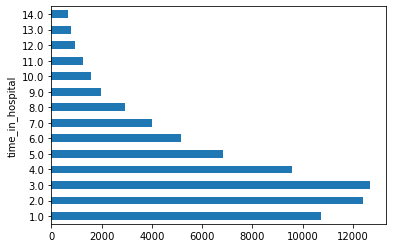

In [37]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     6514
2.0     7374
3.0     7594
4.0     5802
5.0     4082
6.0     3116
7.0     2372
8.0     1771
9.0     1156
10.0     913
11.0     746
12.0     585
13.0     495
14.0     391
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


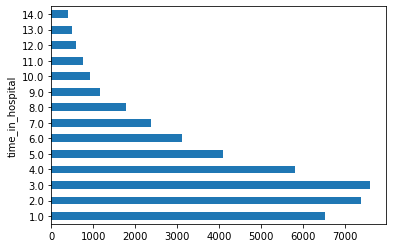

In [38]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2093
2.0     2484
3.0     2606
4.0     1877
5.0     1397
6.0     1034
7.0      793
8.0      595
9.0      419
10.0     327
11.0     229
12.0     173
13.0     142
14.0     134
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


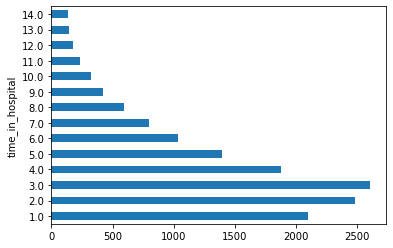

In [39]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

race
?                   1948
AfricanAmerican    12887
Asian                497
Caucasian          53491
Hispanic            1517
Other               1178
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


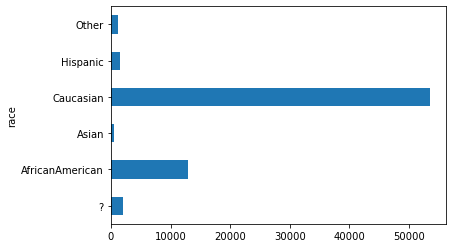

In [40]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'race')

race
?                   1194
AfricanAmerican     7767
Asian                288
Caucasian          32059
Hispanic             897
Other                706
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


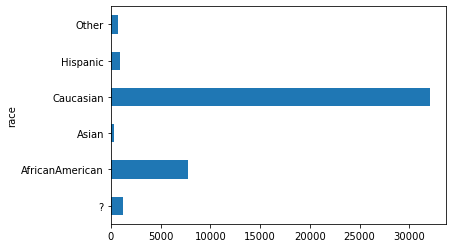

In [41]:
# Training partition
show_group_stats_viz(d_train, 'race')

race
?                    369
AfricanAmerican     2479
Asian                108
Caucasian          10807
Hispanic             295
Other                245
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


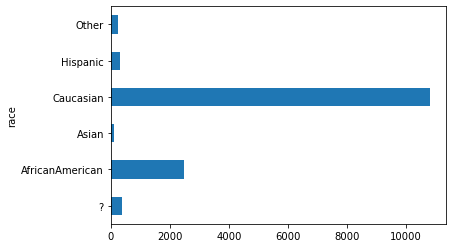

In [42]:
# Test partition
show_group_stats_viz(d_test, 'race')

## Convert Pandas Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended-https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [43]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [44]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 3. Create Categorical/Numerical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [45]:
vocab_file_list = build_vocab_files(d_train, categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API https://www.tensorflow.org/api_docs/python/tf/feature_column.

In [46]:
from utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(categorical_col_list)

INFO:tensorflow:vocabulary_size = 9 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 26 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.
INFO:tensorflow:vocabulary_size = 16 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 645 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 11340 in other_diagnosis_codes is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/other_d

In [47]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='admission_type_id', vocabulary_file='./diabetes_vocab/admission_type_id_vocab.txt', vocabulary_size=9, num_oov_buckets=0, dtype=tf.string, default_value=-1))

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.

## Create Numerical Features with TF Feature Columns

Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [48]:
from utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [49]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [50]:
tf_cont_col_list = create_tf_numerical_feature_cols(numerical_col_list, d_train)

In [51]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='number_outpatient', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7e88a717d9e0>, mean=0.0018954566361190153, std=1.0013352124296497))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[-0.26354793]
 [ 0.6707028 ]
 [-0.26354793]
 [-0.26354793]
 [-0.26354793]
 [-0.26354793]
 [-0.26354793]
 [-0.26354793]
 [-0.26354793]
 [-0.26354793]
 [-0.26354793]
 [-0.26354793]
 [ 1.6049535 ]
 [-0.26354793]
 [-0.26354793]
 [-0.263547

# 4. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [52]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc.

In [53]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [54]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=10)

Train for 336 steps, validate for 112 steps
Epoch 1/10
336/336 [==============================] - 22s 67ms/step - loss: 26.8191 - mse: 26.7603 - val_loss: 23.6488 - val_mse: 23.2112
Epoch 2/10
336/336 [==============================] - 19s 58ms/step - loss: 17.4867 - mse: 16.8203 - val_loss: 14.9518 - val_mse: 14.2988
Epoch 3/10
336/336 [==============================] - 18s 54ms/step - loss: 12.8049 - mse: 11.9063 - val_loss: 12.2361 - val_mse: 11.2276
Epoch 4/10
336/336 [==============================] - 19s 57ms/step - loss: 11.2065 - mse: 10.3234 - val_loss: 11.5551 - val_mse: 10.6184
Epoch 5/10
336/336 [==============================] - 17s 52ms/step - loss: 10.3303 - mse: 9.3611 - val_loss: 10.2928 - val_mse: 9.3436
Epoch 6/10
336/336 [==============================] - 19s 55ms/step - loss: 9.3511 - mse: 8.3590 - val_loss: 9.6378 - val_mse: 8.8091
Epoch 7/10
336/336 [==============================] - 18s 53ms/step - loss: 9.1580 - mse: 8.2728 - val_loss: 9.2093 - val_mse: 8.4410


## Show Model Uncertainty Range with TF Probability

Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction.

In [55]:
feature_list = categorical_col_list + numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [56]:
from utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [57]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [58]:
prob_output_df.head(10)

,pred,actual_value,pred_mean,pred_std
0,5.183154,1.0,1.238459,0.699655
1,2.970129,5.0,3.597044,0.696731
2,3.955182,7.0,4.105596,0.697605
3,1.357379,6.0,4.475534,0.696781
4,7.130611,2.0,2.311122,0.699193
5,3.260943,4.0,4.397435,0.696414
6,3.970979,3.0,2.387021,0.699232
7,6.090179,3.0,4.472603,0.698411
8,3.818567,14.0,9.557044,0.689271
9,1.519966,3.0,1.400449,0.700600


## Convert Regression Output to Classification Output for Patient Selection

Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [59]:
from utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [60]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [61]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head(10)

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,3171447,Female,Caucasian,1.0,0,0
1,2749761,Female,Caucasian,5.0,0,1
2,94810581,Male,Caucasian,7.0,0,1
3,4022649,Male,Caucasian,6.0,0,1
4,25963416,Female,AfricanAmerican,2.0,0,0
5,4267854,Male,Hispanic,4.0,0,0
6,16037757,Female,Caucasian,3.0,0,0
7,21120804,Female,Caucasian,3.0,0,0
8,58982895,Female,Caucasian,14.0,1,1
9,17225532,Female,AfricanAmerican,3.0,0,0


## Model Evaluation Metrics 

Use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

In [62]:
# AUC, F1, precision and recall
print(classification_report(pred_test_df['label_value'], pred_test_df['score']))

              precision    recall  f1-score   support

           0       0.74      0.94      0.83      9060
           1       0.81      0.44      0.57      5243

    accuracy                           0.76     14303
   macro avg       0.78      0.69      0.70     14303
weighted avg       0.77      0.76      0.74     14303



In [63]:
f1 = f1_score(pred_test_df['label_value'], pred_test_df['score'], average='weighted')
print('f1 score (weighted): {}'.format(f1))

f1 score (weighted): 0.7372480683446481


In [64]:
auc = roc_auc_score(pred_test_df['label_value'], pred_test_df['score'])
print('AUC: {}'.format(auc))

AUC: 0.6922588574948454


In our algorithm, precision holds paramount importance, signifying our capability to accurately predict patients who will stay in the hospital for more than 5 days (termed 'eligible' patients) while minimizing the likelihood of falsely categorizing patients who won't stay beyond 5 days. Conversely, recall serves to mitigate the risk of incorrectly classifying eligible patients as ineligible. Given our objective to identify eligible patients to mitigate additional costs, both metrics bear significance. However, precision takes precedence, as missing out on eligible patients is less detrimental than incurring avoidable costs.

For subsequent iterations, it's advisable to balance the training dataset, ensuring a similar representation of eligible and non-eligible patients to prevent bias towards the more prevalent non-eligible category. But we will still keep the raw proportion of outcome in the test and validation dataset. Moreover, We can adjust and try different hyperparameters combinations in the deep learning model. And we can try different prior information to do the sensitivity analysis.



# 5. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [65]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


model_id, score_thresholds 1 {'rank_abs': [2848]}


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)
/opt/conda/lib/python3.7/site-packages/aequitas/group.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  divide = lambda x, y: x / y if y != 0 else pd.np.nan


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [66]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

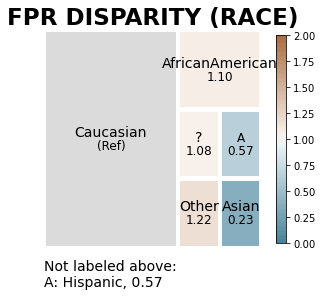

In [67]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?
fpr_disparity_race = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                        attribute_name='race')

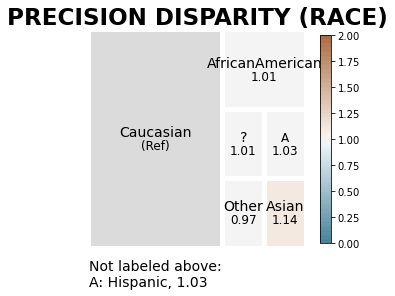

In [68]:
precision_disparity_gender = aqp.plot_disparity(bdf, group_metric='precision_disparity', 
                                       attribute_name='race')

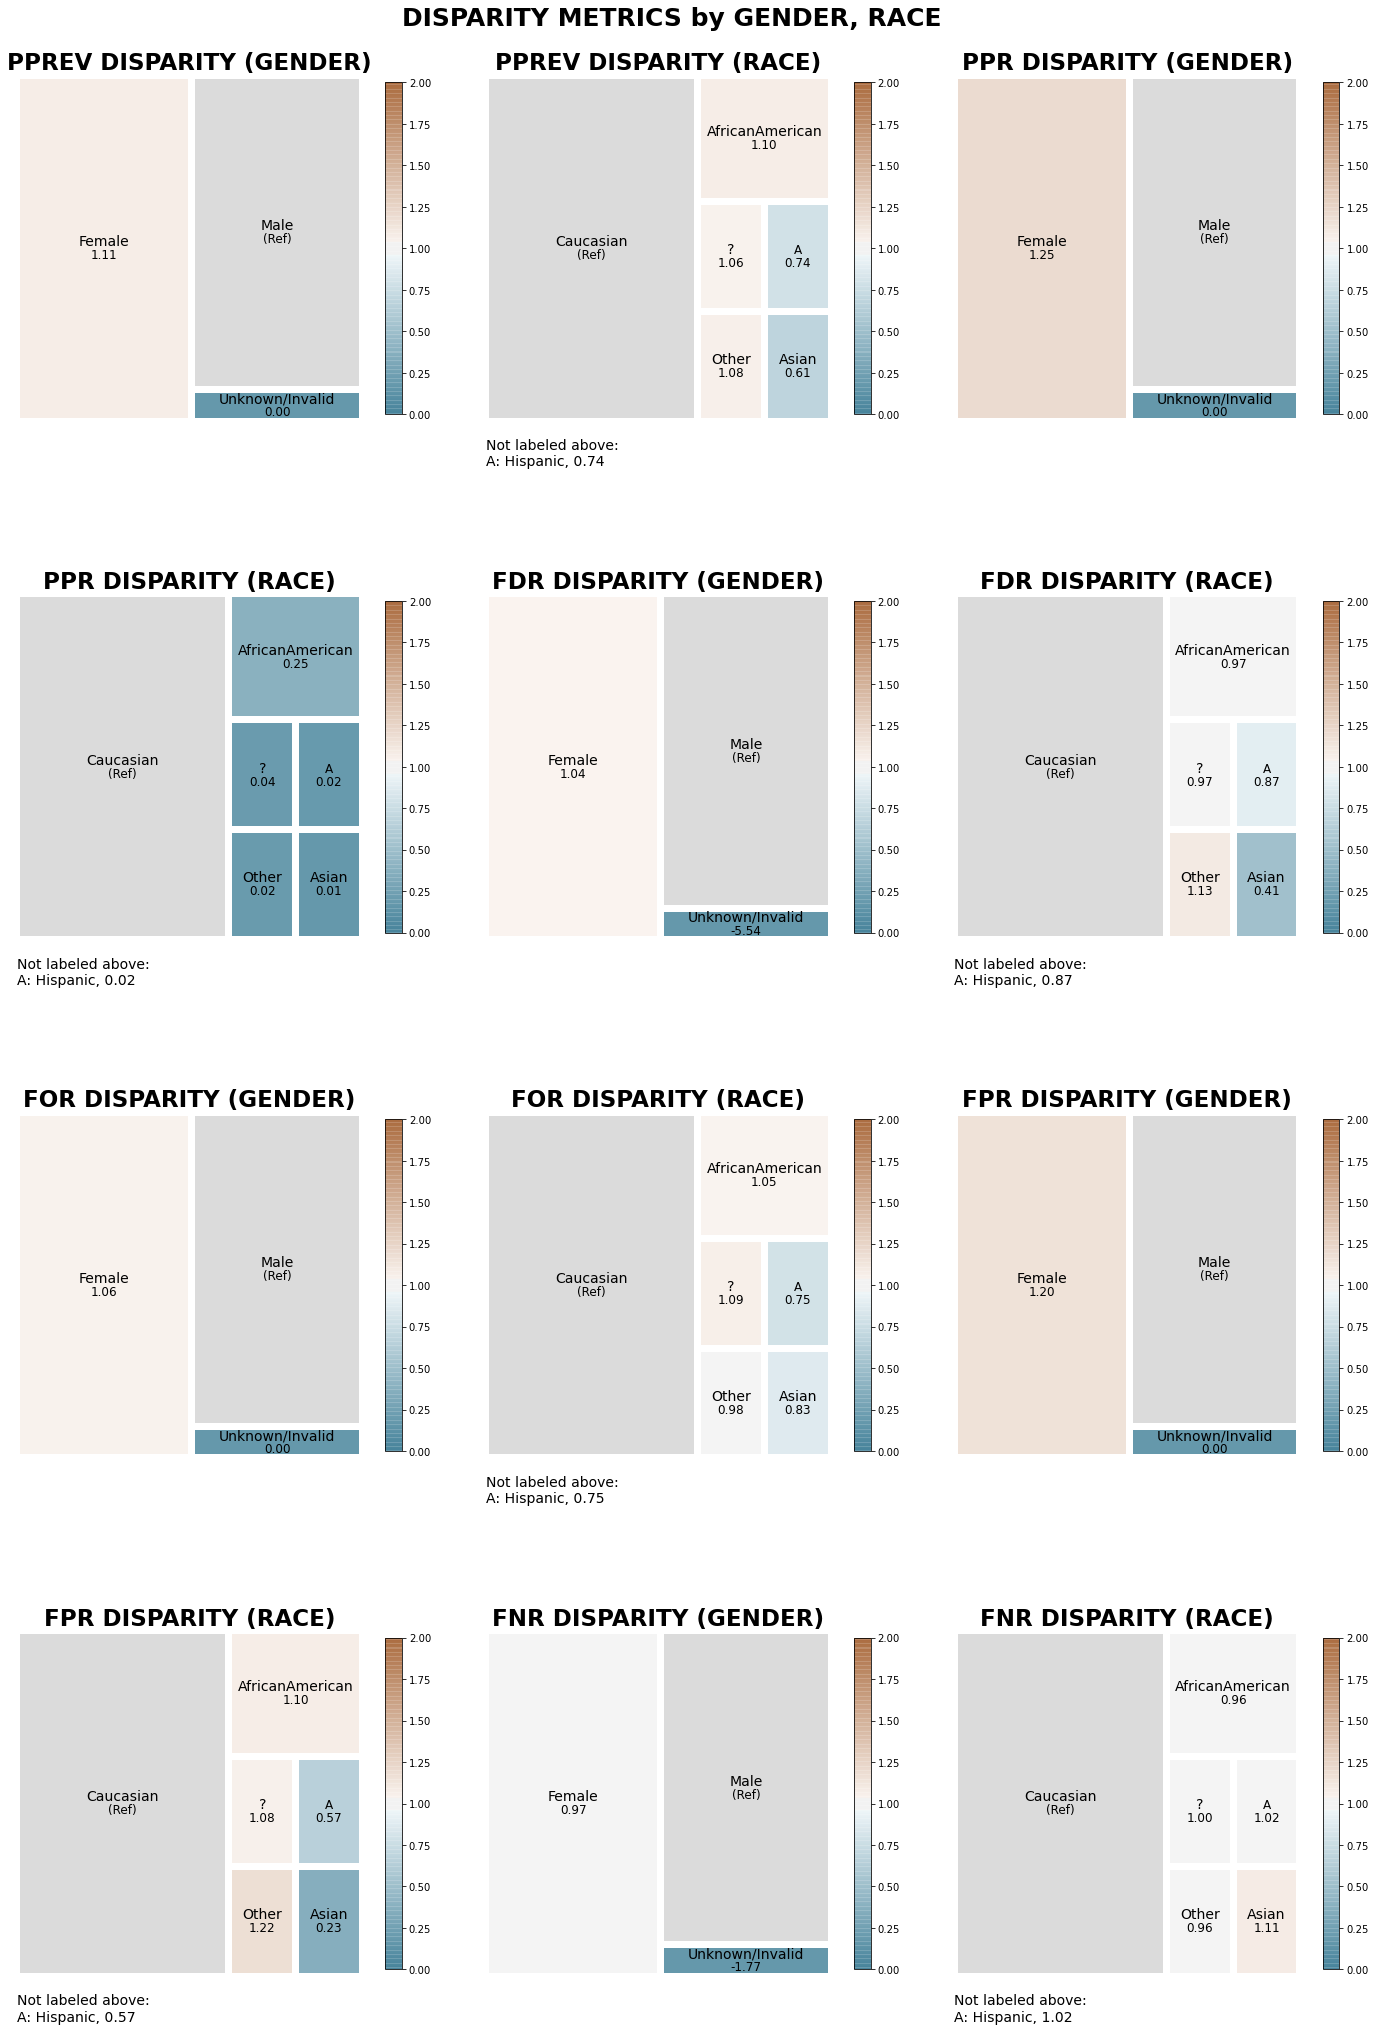

In [69]:
# Plot all disparities to see if I missed some
all_disparities = aqp.plot_disparity_all(bdf, attributes=['gender', 'race'])

Upon examination, there appears to be minimal gender-based disparity. However, a notable racial disparity emerges, particularly among Hispanic and Asian patients. Remarkably, Hispanic patients face approximately 3 times fewer instances of being falsely labeled compared to Caucasians. For precision disparity, the algorithm demonstrates roughly 25% lower precision when dealing with Asian patients compared to reference group.

## Fairness Analysis Example - Relative to a Reference Group 

Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

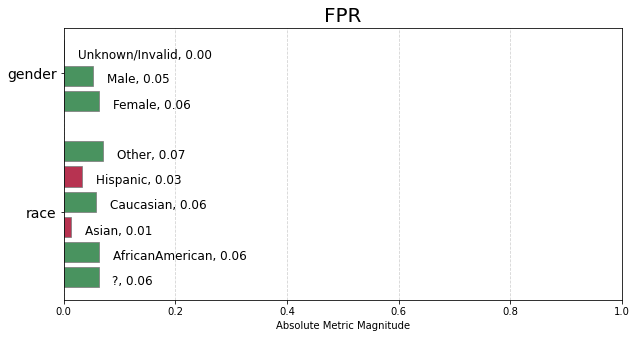

In [70]:
# Reference group fairness plot
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

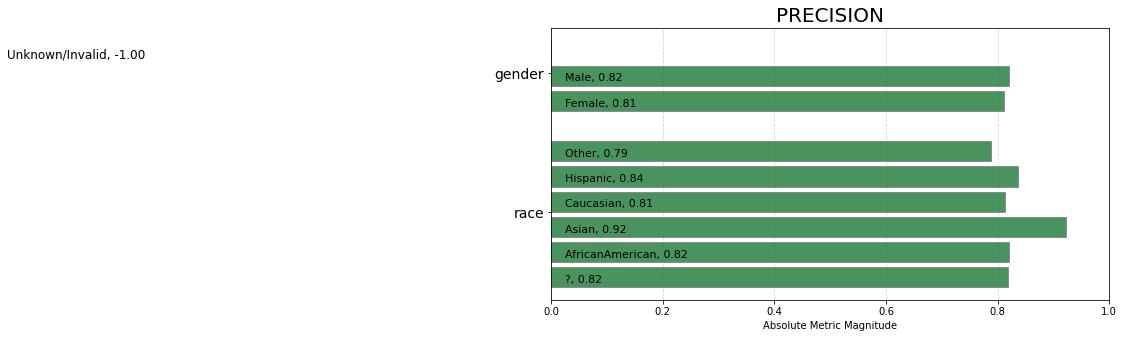

In [71]:
prec_fairness = aqp.plot_fairness_group(fdf, group_metric='precision', title=True)

There is a disparity for false positive rate for Hispanic race and precision disparity for the asian race

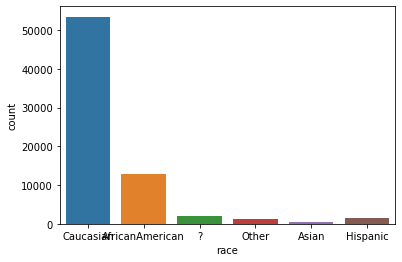

In [72]:
ax = sns.countplot(x="race", data=agg_drug_df)

In [73]:
asian_agg_df = agg_drug_df[agg_drug_df["race"]=="Asian"]
hispanic_agg_df = agg_drug_df[agg_drug_df["race"]=="Hispanic"]
Asian= sum(asian_agg_df["time_in_hospital"]>=5)/len(asian_agg_df)
Hispanic=sum(asian_agg_df["time_in_hospital"]>=5)/len(hispanic_agg_df)
All=sum(agg_drug_df["time_in_hospital"]>=5)/len(agg_drug_df)

In [74]:
print('% eligible patients: {}'.format(All))
print('% eligible patients in Asian: {}'.format(Asian))
print('% eligible patients in Hispanic: {}'.format(Hispanic))

% eligible patients: 0.3654464610307894
% eligible patients in Asian: 0.289738430583501
% eligible patients in Hispanic: 0.09492419248516809


We can see the number of caucasian patients is much larger than Asian and Hispanic, and the % eligible patients of caucasian patients is also much larger, so I think the disparity problem is caused by the less sample size of certian race group, which is not representative.